## 12/ Réaliser un clustering pour répondre à la question combien de forfaits faudrait-il proposer?

(Le loueur veut faire un forfait en fonction de la météo pour encourager à faire du vélo quand la météo est moins bonne.)

Data Fields

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

# Sommaire

- 1. Preprocessing 
- 1.1 Feature matrix
- 1.2 Normalisation
- 2. MEP des clusters
- 2.1 Elbow method (wcss)
- 2.2 Kmeans (label.kmeans)
- 3. Reduction de dimention avec ACP
- 3.1 Elbow method (Explained_variance_ratio)
- 3.2 ACP (weather)
- 3.3 Analyse des 4 clusters de weather 
- 3.4 ACP (label_kmeans)
- 3.5 Analyse des 4 clusters de label_kmeans
- 4. Reduction de dimention avec T-sne
- 4.1 T-sne (weather)
- 4.2 T-sne (label_kmeans)
- 4.3 Analyse
- 5. Dataviz 3D
- 5.1 Scatter plot 3D (weather)
- 5.2 Scatter plot 3D (label.kmeans)
- 5.3 Analyse
- 6. Obtenir 95% de variabilité (pas clair)
- 7. Mesure des performances (Score silhouette)
- 7.1 Score silhouette (weather)
- 7.2 Score silhouette (label_kmeans)
- 7.3 Analyse
- 8. ARI 
- 9. Regression sur label_kmeans
- 10. Combien de forfaits faudrait-il proposer?

In [97]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_rand_score

In [98]:
df = pd.read_csv("/home/michelle/Documents/DEV_IA/Projet/Brief_machine_learning_Vlille_210322/Rendu/data/train.csv")

In [99]:
df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [100]:
df.shape

(10886, 12)

In [101]:
# Traitement des types 

#df["datetime"]= df["datetime"].astype("datetime64")

#df['datetime'] = pd.to_numeric(pd.to_datetime(df['datetime']))

# 1. Preprocessing 

J'ai cree 2 df à partir du df original afin de travailler d'une part sur les clusters existant (weather), et d'autre part sur la nouvelle cols labels_kmeans, puis j'ai mis le tout en ndarray

## 1.1 Feature matrix

In [102]:
# labels_kmeans
X = df[['temp', 'atemp','humidity','windspeed']].values
X.shape

(10886, 4)

In [103]:
#weather
X1 = df[['temp', 'atemp','humidity','windspeed','weather']].values
X1.shape

(10886, 5)

In [144]:
X2 = df[['temp', 'atemp','humidity','windspeed','weather']]
X2.shape

(10886, 5)

In [145]:
X2

temp   atemp  humidity  windspeed  weather
0       9.84  14.395        81     0.0000        1
1       9.02  13.635        80     0.0000        1
2       9.02  13.635        80     0.0000        1
3       9.84  14.395        75     0.0000        1
4       9.84  14.395        75     0.0000        1
...      ...     ...       ...        ...      ...
10881  15.58  19.695        50    26.0027        1
10882  14.76  17.425        57    15.0013        1
10883  13.94  15.910        61    15.0013        1
10884  13.94  17.425        61     6.0032        1
10885  13.12  16.665        66     8.9981        1

[10886 rows x 5 columns]

## 1.2 Normalisation 

Standardisation avec StandardScaler pour les besoins de l'ACP


In [104]:
#labels_kmeans

# Create the object
scaler = StandardScaler()

# Calculate the mean and standard deviation
scaler.fit(X)

# Transform the values
X_scaled = scaler.transform(X)

In [105]:
#weather

# Create the object
scaler = StandardScaler()

# Calculate the mean and standard deviation
scaler.fit(X1)

# Transform the values
X1_scaled = scaler.transform(X1)

# 2. MEP des clusters

## 2.1 Elbow method (wcss)

In [106]:
X

array([[ 9.84  , 14.395 , 81.    ,  0.    ],
       [ 9.02  , 13.635 , 80.    ,  0.    ],
       [ 9.02  , 13.635 , 80.    ,  0.    ],
       ...,
       [13.94  , 15.91  , 61.    , 15.0013],
       [13.94  , 17.425 , 61.    ,  6.0032],
       [13.12  , 16.665 , 66.    ,  8.9981]])

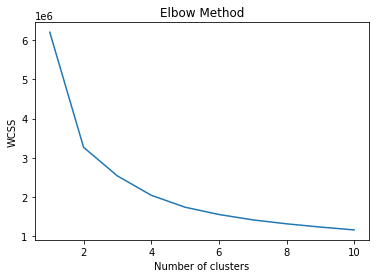

In [107]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Axe y => WCSS(within-cluster sums of squares)
Somme de la distance au carré entre chaque membre du cluster et son centroïde.

Axe x => Nombre de clusters

## 2.2 Kmeans

In [108]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)
labels_kmeans = kmeans.labels_

# 3. Reduction de dimension avec ACP

## 3.1 Elbow method (Explained_variance_ratio)

In [109]:
model = PCA(n_components = 4)

model.fit(X_scaled)

model_X = model.transform(X_scaled)

In [110]:

np.cumsum(model.explained_variance_ratio_ * 100)

array([ 49.79505333,  82.76800678,  99.64466711, 100.        ])

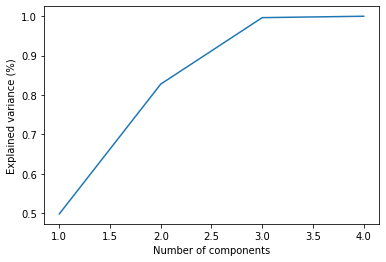

In [111]:
# Elbow method(méthode du coude)
X_label = [1,2,3,4]
plt.plot(X_label, np.cumsum(model.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.savefig("elbow_plot.png", dpi=100)

In [112]:
np.cumsum(model.explained_variance_ratio_)

array([0.49795053, 0.82768007, 0.99644667, 1.        ])

In [113]:
print("Variance explained by the First principal component =",
     np.cumsum(model.explained_variance_ratio_ * 100)[0])

print("Variance explained by the First 2 component =",
     np.cumsum(model.explained_variance_ratio_ * 100)[1])

print("Variance explained by the First 3 component =",
     np.cumsum(model.explained_variance_ratio_ * 100)[2])

print("Variance explained by the First 4 principal component =",
     np.cumsum(model.explained_variance_ratio_ * 100)[3])

Variance explained by the First principal component = 49.79505332610716
Variance explained by the First 2 component = 82.76800677879841
Variance explained by the First 3 component = 99.64466711176506
Variance explained by the First 4 principal component = 99.99999999999999


## 3.2 ACP (weather)

En creant un scatter plot 2d, Cela renverra 2 composants qui capturent 82.76 % de la variabilité des données.

In [114]:
model = PCA(n_components = 4)

model.fit(X1_scaled)

model_X1 = model.transform(X1_scaled)

In [115]:
#ACP
pca_2 = PCA(n_components=2, random_state=2020)
pca_2.fit(X1_scaled)
X1_pca_2 = pca_2.transform(X1_scaled)

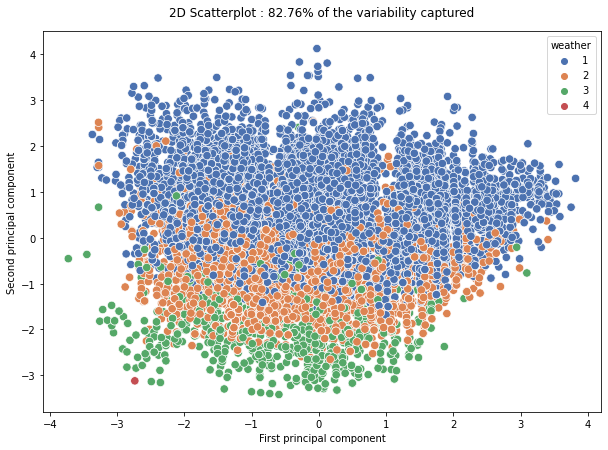

In [116]:
# Scatter plot de "weather"
plt.figure(figsize=(10,7))
sns.scatterplot(x=X1_pca_2[:,0], y=X1_pca_2[:,1], s=70,
                hue=df.weather, palette="deep")
plt.title("2D Scatterplot : 82.76% of the variability captured", pad=15)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig("2d_scatterplot.png")

In [117]:
#Describe des 4 clusters de weather

for label in df["weather"].unique():
    display(df[df["weather"] == label].describe())

season      holiday   workingday  weather         temp  \
count  7192.00000  7192.000000  7192.000000   7192.0  7192.000000   
mean      2.49708     0.028365     0.672831      1.0    20.557122   
std       1.10119     0.166024     0.469212      0.0     8.144427   
min       1.00000     0.000000     0.000000      1.0     0.820000   
25%       2.00000     0.000000     0.000000      1.0    13.940000   
50%       3.00000     0.000000     1.000000      1.0    20.500000   
75%       3.00000     0.000000     1.000000      1.0    27.060000   
max       4.00000     1.000000     1.000000      1.0    41.000000   

             atemp     humidity    windspeed       casual   registered  \
count  7192.000000  7192.000000  7192.000000  7192.000000  7192.000000   
mean     23.994126    56.716769    12.892542    40.308676   164.928115   
std       8.869844    17.652654     8.287707    53.443710   155.294051   
min       0.760000     8.000000     0.000000     0.000000     0.000000   
25%      16.665000    43.000000     7.001500     5.000000    41.000000   
50%      24.240000    56.000000    12.998000    20.000000   130.000000   
75%      31.060000    70.000000    19.001200    55.000000   236.000000   
max      45.455000   100.000000    51.998700   367.000000   886.000000   

             count  
count  7192.000000  
mean    205.236791  
std     187.959566  
min       1.000000  
25%      48.000000  
50%     161.000000  
75%     305.000000  
max     977.000000

season      holiday   workingday  weather         temp  \
count  2834.000000  2834.000000  2834.000000   2834.0  2834.000000   
mean      2.530346     0.032463     0.683486      2.0    19.614608   
std       1.150498     0.177257     0.465198      0.0     7.172559   
min       1.000000     0.000000     0.000000      2.0     3.280000   
25%       1.000000     0.000000     0.000000      2.0    13.940000   
50%       2.000000     0.000000     1.000000      2.0    18.860000   
75%       4.000000     0.000000     1.000000      2.0    25.420000   
max       4.000000     1.000000     1.000000      2.0    39.360000   

             atemp     humidity    windspeed       casual   registered  \
count  2834.000000  2834.000000  2834.000000  2834.000000  2834.000000   
mean     23.072414    69.100565    12.179905    30.785462   148.170078   
std       7.781651    17.281073     7.600776    43.027108   144.765721   
min       2.275000     0.000000     0.000000     0.000000     0.000000   
25%      16.665000    56.000000     7.001500     4.000000    35.000000   
50%      22.725000    70.000000    11.001400    15.000000   112.000000   
75%      29.545000    83.000000    16.997900    40.000000   211.000000   
max      43.180000   100.000000    47.998800   350.000000   788.000000   

             count  
count  2834.000000  
mean    178.955540  
std     168.366413  
min       1.000000  
25%      41.000000  
50%     134.000000  
75%     264.000000  
max     890.000000

season     holiday  workingday  weather        temp       atemp  \
count  859.000000  859.000000  859.000000    859.0  859.000000  859.000000   
mean     2.509895    0.017462    0.739232      3.0   19.546356   22.753091   
std      1.125393    0.131062    0.439310      0.0    6.449593    6.980990   
min      1.000000    0.000000    0.000000      3.0    3.280000    2.275000   
25%      2.000000    0.000000    0.000000      3.0   14.760000   17.425000   
50%      2.000000    0.000000    1.000000      3.0   19.680000   23.485000   
75%      4.000000    0.000000    1.000000      3.0   24.600000   27.275000   
max      4.000000    1.000000    1.000000      3.0   37.720000   44.695000   

         humidity   windspeed      casual  registered       count  
count  859.000000  859.000000  859.000000  859.000000  859.000000  
mean    81.341094   14.071248   17.442375  101.403958  118.846333  
std     18.039876    8.731668   31.993259  119.344152  138.581297  
min      0.000000    0.000000    0.000000    0.000000    1.000000  
25%     76.000000    7.999800    1.000000   21.500000   23.000000  
50%     87.000000   12.998000    6.000000   64.000000   71.000000  
75%     93.000000   19.001200   18.500000  134.000000  161.000000  
max    100.000000   56.996900  263.000000  791.000000  891.000000

season  holiday  workingday  weather  temp   atemp  humidity  \
count     1.0      1.0         1.0      1.0   1.0   1.000       1.0   
mean      1.0      0.0         1.0      4.0   8.2  11.365      86.0   
std       NaN      NaN         NaN      NaN   NaN     NaN       NaN   
min       1.0      0.0         1.0      4.0   8.2  11.365      86.0   
25%       1.0      0.0         1.0      4.0   8.2  11.365      86.0   
50%       1.0      0.0         1.0      4.0   8.2  11.365      86.0   
75%       1.0      0.0         1.0      4.0   8.2  11.365      86.0   
max       1.0      0.0         1.0      4.0   8.2  11.365      86.0   

       windspeed  casual  registered  count  
count     1.0000     1.0         1.0    1.0  
mean      6.0032     6.0       158.0  164.0  
std          NaN     NaN         NaN    NaN  
min       6.0032     6.0       158.0  164.0  
25%       6.0032     6.0       158.0  164.0  
50%       6.0032     6.0       158.0  164.0  
75%       6.0032     6.0       158.0  164.0  
max       6.0032     6.0       158.0  164.0

## 3.3 Analyse des 4 clusters de weather 

- Cluster 1 : 7192  => Clear, Few clouds, Partly cloudy, Partly cloudy
- Cluster 2 : 2834  => Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- Cluster 3 : 859   => Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- Cluster 4 : 1     => Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

On constate 1 seule entré dans le cluster 4, soit en cas de très mauvais temps
Temp moy : 8.2
Ressenti : 11.365	
Humidité : 86.0	
Vents : 6.0032, 

en cas de mauvais temps (cluster 3), le nombre d'utilisateurs est de 859
Temp moy : 19.546356	
Ressenti : 22.753091	
Humidité : 81.341094	
Vents : 14.071248

## 3.4 ACP labels_kmeans

In [118]:
#ACP
pca_2 = PCA(n_components=2, random_state=2020)
pca_2.fit(X_scaled)
X_pca_2 = pca_2.transform(X_scaled)

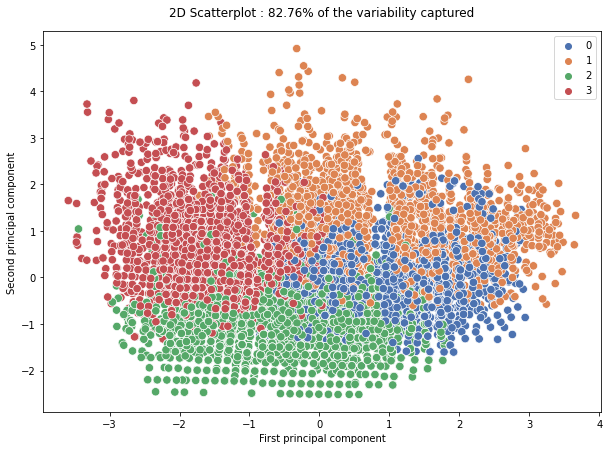

In [119]:
# Scatter plot de labels_kmeans (X), soit 4 clusters

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca_2[:,0], y=X_pca_2[:,1], s=70,
                hue=labels_kmeans, palette="deep")
plt.title("2D Scatterplot : 82.76% of the variability captured", pad=15)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig("2d_scatterplot.png")

In [120]:
# Ajout de la colonne "label_kmeans" au df

df["label_kmeans"] = labels_kmeans

In [121]:
for i in range(4):
  print("Cluster number {} ({} values)".format(i, df[labels_kmeans==i].shape[0]))
  display(df[labels_kmeans==i].describe())

Cluster number 0 (2692 values)


season      holiday   workingday      weather         temp  \
count  2692.000000  2692.000000  2692.000000  2692.000000  2692.000000   
mean      2.732169     0.032318     0.684621     1.339153    26.215936   
std       0.759895     0.176876     0.464753     0.548419     4.420803   
min       1.000000     0.000000     0.000000     1.000000    14.760000   
25%       2.000000     0.000000     0.000000     1.000000    22.960000   
50%       3.000000     0.000000     1.000000     1.000000    26.240000   
75%       3.000000     0.000000     1.000000     2.000000    29.520000   
max       4.000000     1.000000     1.000000     3.000000    35.260000   

             atemp     humidity    windspeed       casual   registered  \
count  2692.000000  2692.000000  2692.000000  2692.000000  2692.000000   
mean     30.461971    62.864042    12.073450    50.446880   188.984027   
std       4.869498     7.383487     7.224767    51.591272   161.404434   
min      12.120000    47.000000     0.000000     0.000000     1.000000   
25%      26.515000    57.000000     7.001500    14.000000    71.000000   
50%      31.060000    63.000000    11.001400    37.000000   157.000000   
75%      34.090000    69.000000    16.997900    68.000000   256.250000   
max      42.425000    79.000000    43.000600   367.000000   833.000000   

             count  label_kmeans  
count  2692.000000        2692.0  
mean    239.430906           0.0  
std     189.496197           0.0  
min       1.000000           0.0  
25%      94.000000           0.0  
50%     207.000000           0.0  
75%     343.000000           0.0  
max     917.000000           0.0

Cluster number 1 (2091 values)


season      holiday   workingday      weather         temp  \
count  2091.000000  2091.000000  2091.000000  2091.000000  2091.000000   
mean      2.372071     0.017695     0.692970     1.150167    25.490588   
std       0.948564     0.131871     0.461372     0.403838     6.641748   
min       1.000000     0.000000     0.000000     1.000000     9.020000   
25%       2.000000     0.000000     0.000000     1.000000    20.500000   
50%       2.000000     0.000000     1.000000     1.000000    25.420000   
75%       3.000000     0.000000     1.000000     1.000000    31.160000   
max       4.000000     1.000000     1.000000     3.000000    41.000000   

             atemp     humidity    windspeed       casual   registered  \
count  2091.000000  2091.000000  2091.000000  2091.000000  2091.000000   
mean     29.160227    36.614060    16.315788    80.511239   244.631755   
std       6.691972     8.707186     8.780511    67.239245   154.464090   
min      12.120000     0.000000     0.000000     0.000000     0.000000   
25%      24.240000    31.000000    11.001400    33.000000   141.000000   
50%      31.060000    38.000000    16.997900    63.000000   215.000000   
75%      33.335000    43.000000    19.999500   105.000000   317.000000   
max      45.455000    52.000000    56.996900   361.000000   886.000000   

             count  label_kmeans  
count  2091.000000        2091.0  
mean    325.142994           1.0  
std     190.255897           0.0  
min       1.000000           1.0  
25%     184.000000           1.0  
50%     289.000000           1.0  
75%     440.000000           1.0  
max     977.000000           1.0

Cluster number 2 (3527 values)


season      holiday  workingday      weather         temp  \
count  3527.000000  3527.000000  3527.00000  3527.000000  3527.000000   
mean      2.674227     0.027502     0.67366     1.749362    18.753519   
std       1.128536     0.163564     0.46894     0.756600     6.109323   
min       1.000000     0.000000     0.00000     1.000000     3.280000   
25%       2.000000     0.000000     0.00000     1.000000    13.940000   
50%       3.000000     0.000000     1.00000     2.000000    18.860000   
75%       4.000000     0.000000     1.00000     2.000000    23.780000   
max       4.000000     1.000000     1.00000     4.000000    29.520000   

             atemp     humidity    windspeed       casual   registered  \
count  3527.000000  3527.000000  3527.000000  3527.000000  3527.000000   
mean     22.182411    83.721009     9.714584    14.755883   102.906436   
std       6.340163     7.590473     7.078429    23.060617   126.165836   
min       2.275000    66.000000     0.000000     0.000000     0.000000   
25%      17.425000    78.000000     6.003200     2.000000    14.000000   
50%      22.725000    83.000000     8.998100     6.000000    58.000000   
75%      27.275000    88.000000    12.998000    18.000000   140.000000   
max      35.605000   100.000000    43.000600   249.000000   806.000000   

             count  label_kmeans  
count  3527.000000        3527.0  
mean    117.662319           2.0  
std     137.790330           0.0  
min       1.000000           2.0  
25%      17.000000           2.0  
50%      69.000000           2.0  
75%     168.000000           2.0  
max     839.000000           2.0

Cluster number 3 (2576 values)


season      holiday   workingday      weather         temp  \
count  2576.000000  2576.000000  2576.000000  2576.000000  2576.000000   
mean      2.150621     0.034938     0.677019     1.265916    11.729565   
std       1.398412     0.183658     0.467706     0.479015     3.753415   
min       1.000000     0.000000     0.000000     1.000000     0.820000   
25%       1.000000     0.000000     0.000000     1.000000     9.020000   
50%       1.000000     0.000000     1.000000     1.000000    12.300000   
75%       4.000000     0.000000     1.000000     1.000000    13.940000   
max       4.000000     1.000000     1.000000     3.000000    31.160000   

             atemp     humidity    windspeed       casual   registered  \
count  2576.000000  2576.000000  2576.000000  2576.000000  2576.000000   
mean     14.089371    51.483696    14.927345    13.951475   120.388199   
std       4.456688     9.344441     8.239739    20.985681   124.103336   
min       0.760000    25.000000     0.000000     0.000000     0.000000   
25%      11.365000    45.000000     8.998100     2.000000    29.000000   
50%      14.395000    51.000000    15.001300     7.000000    86.000000   
75%      16.665000    59.000000    19.999500    17.000000   170.000000   
max      25.000000    71.000000    51.998700   258.000000   773.000000   

             count  label_kmeans  
count  2576.000000        2576.0  
mean    134.339674           3.0  
std     134.768026           0.0  
min       1.000000           3.0  
25%      32.000000           3.0  
50%      95.000000           3.0  
75%     193.000000           3.0  
max     798.000000           3.0

## 3.5 Analyse des 4 clusters de label_kmeans 
                        temp	atemp	humidity	windspeed
- Cluster 0 : 2692  => 26.215936,	30.461971,	62.864042,	12.073450
- Cluster 1 : 2091  => 25.490588,	29.160227,	36.614060,	16.315788
- Cluster 2 : 3527  => 18.753519,	22.182411,	83.721009,	9.714584
- Cluster 3 : 2576  => 11.729565,	14.089371,	51.483696,	14.927345

Les clusters semblent plus equilibrés que ce soit dans les caracteristiques ou dans leurs nombres

# 4. Reduction de dimention avec T-sne

## 4.1 TSNE (weather)

In [122]:
#weather
tsne_weather = TSNE().fit_transform(X1_scaled)

In [141]:
tsne_weather.shape

(10886, 2)

In [143]:
X

array([[ 9.84  , 14.395 , 81.    ,  0.    ],
       [ 9.02  , 13.635 , 80.    ,  0.    ],
       [ 9.02  , 13.635 , 80.    ,  0.    ],
       ...,
       [13.94  , 15.91  , 61.    , 15.0013],
       [13.94  , 17.425 , 61.    ,  6.0032],
       [13.12  , 16.665 , 66.    ,  8.9981]])

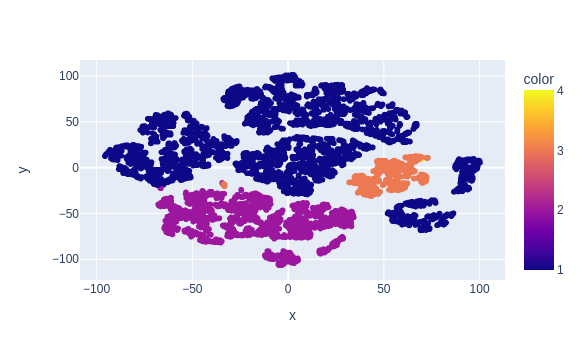

In [147]:
fig_1 = px.scatter(x=tsne_weather[:,0], y=tsne_weather[:,1], color=X2["weather"], data_frame=X1).show()

## 4.2 TSNE (label_kmeans)

In [124]:
#new_feature
tsne_feature = TSNE().fit_transform(X_scaled)

In [139]:
tsne_feature

array([[-21.350924 ,  82.23528  ],
       [-23.230707 ,  82.57281  ],
       [-23.23581  ,  82.57378  ],
       ...,
       [-64.706665 ,  -0.9052275],
       [-45.490753 , -12.443486 ],
       [-66.470146 , -17.157103 ]], dtype=float32)

In [140]:
labels_kmeans

array([2, 2, 2, ..., 3, 3, 3], dtype=int32)

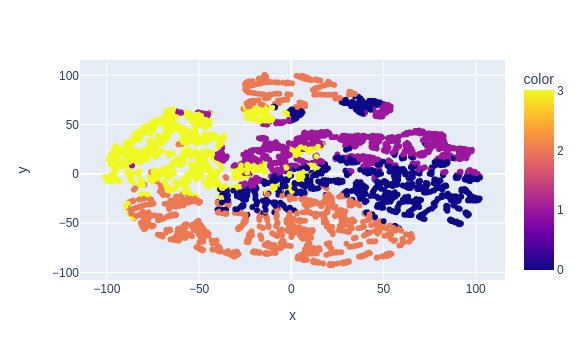

In [125]:
fig_2 = px.scatter(x=tsne_feature[:,0], y=tsne_feature[:,1], color=labels_kmeans, data_frame=X)
fig_2.show()

On constate ques les differents clusters se chevauchent legerement, qu'il n ya pas de clusters clairement isolés

# 5. Dataviz 3D

En creant un scatter plot 3d, Cela renverra 3 composants qui capturent 99.64 % de la variabilité des données.

## 5.1 Scatter plot 3D (weather)

In [126]:
#Apply PCA by setting n_components=3

pca_3 = PCA(n_components=3, random_state=2020)
pca_3.fit(X_scaled)
X_pca_3 = pca_3.transform(X_scaled)

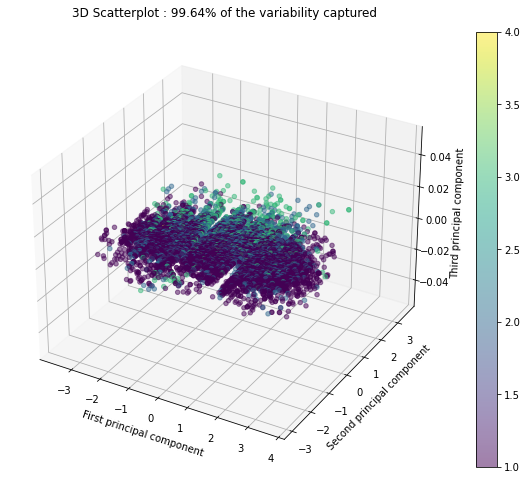

In [167]:
# 3d scatterplot of the data using the values of the three principal components

from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (12,8))
ax = plt.axes(projection="3d")

sctt = ax.scatter3D(X_pca_3[:,0], X_pca_3[:,2],
                   c = df.weather, s=20, alpha=0.5)

plt.title("3D Scatterplot : 99.64% of the variability captured", pad=15)
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_zlabel("Third principal component")
fig.colorbar(sctt)
plt.savefig("3d_scatterplot.png")

## 5.2 Scatter plot 3D (label.kmeans)

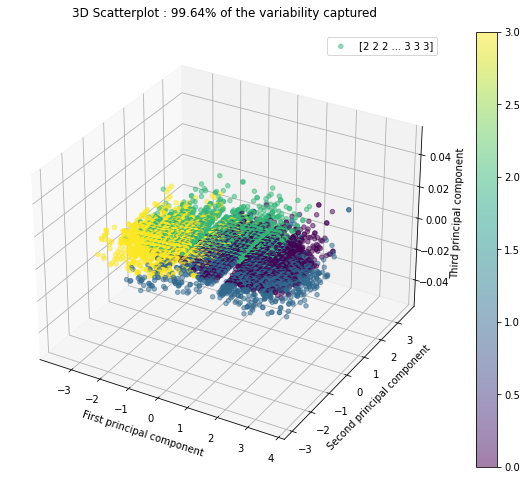

In [160]:
# 3d scatterplot of the data using the values of the three principal components

from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (12,8))
ax = plt.axes(projection="3d")

sctt = ax.scatter3D(X_pca_3[:,0], X_pca_3[:,2],
                   c = labels_kmeans, s=20, alpha=0.5, label=labels_kmeans)

plt.title("3D Scatterplot : 99.64% of the variability captured", pad=15)
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_zlabel("Third principal component")
ax.legend()
fig.colorbar(sctt)
plt.savefig("3d_scatterplot.png")

## 6. Obtenir 95% de variabilité

In [129]:
# Components while preserving 95% of the variability in the data

pca_95 = PCA (n_components=0.95, random_state=2020)
pca_95.fit(X_scaled)
X_pca_95 = pca_95.transform(X_scaled)

In [130]:
# Permet de savoir cbn de components nous gardons preserver 95% de la variabilité

X_pca_95.shape

(10886, 3)

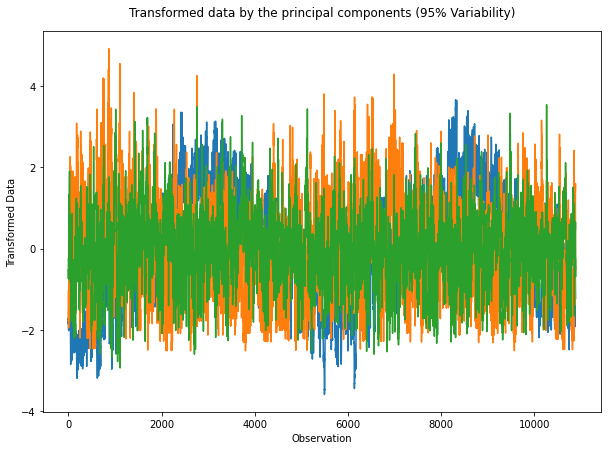

In [131]:
plt.figure(figsize=(10,7))
plt.plot(X_pca_95)
plt.xlabel("Observation")
plt.ylabel("Transformed Data")
plt.title("Transformed data by the principal components (95% Variability)", pad=15)
plt.savefig("plot.png")

# 7. Mesurer les performances 

## 7.1 Score silhouette (labels_kmeans)

La taille/épaisseur des silhouettes est également proportionnelle au nombre d'échantillons à l'intérieur de ce cluster.
Plus les coefficients de silhouette sont élevés (plus ils sont proches de +1), plus les échantillons de la grappe sont éloignés des échantillons des grappes voisines. 
Les valeurs négatives, au contraire, indiquent que ces échantillons ont peut-être été affectés au mauvais cluster.
la moyenne des coefficients de silhouette, nous pouvons obtenir un score de silhouette global qui peut être utilisé pour décrire les performances de l'ensemble de la population avec une seule valeur.

For n_clusters = 2 The average silhouette_score is : 0.3915866346729542
For n_clusters = 3 The average silhouette_score is : 0.35483303080139084
For n_clusters = 4 The average silhouette_score is : 0.31160302381767885
For n_clusters = 5 The average silhouette_score is : 0.2941944161848891
For n_clusters = 6 The average silhouette_score is : 0.27540958576065727
For n_clusters = 7 The average silhouette_score is : 0.2628452700337413
For n_clusters = 8 The average silhouette_score is : 0.2494169850203688


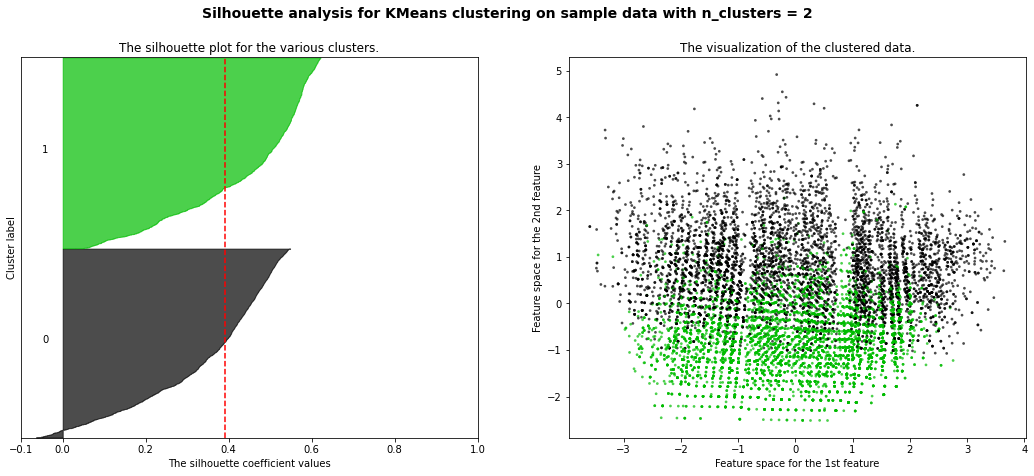

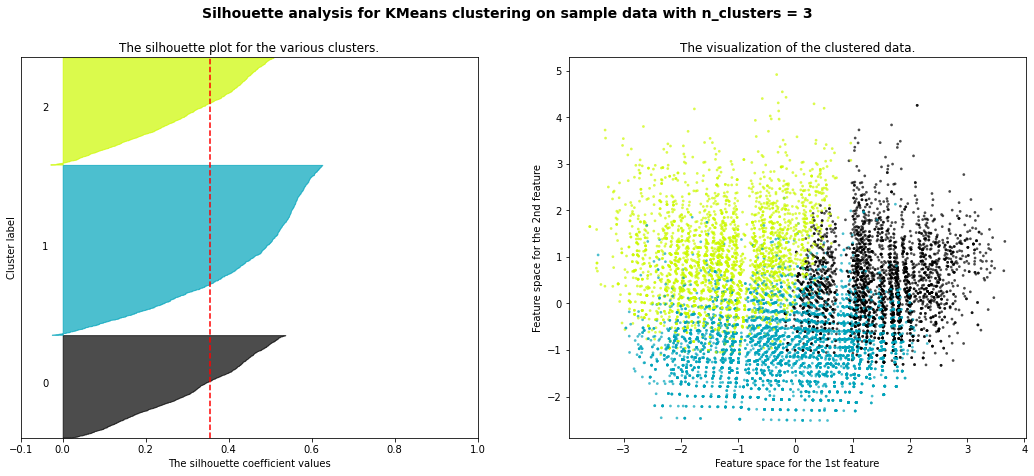

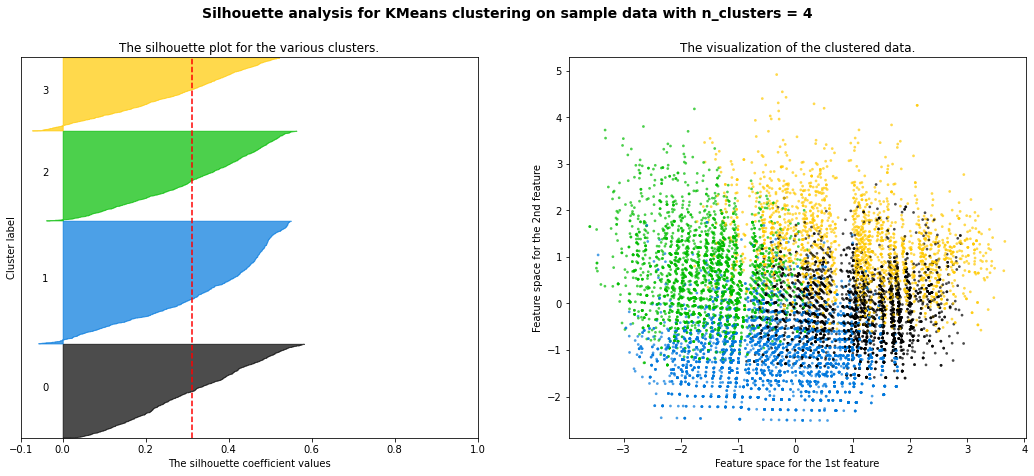

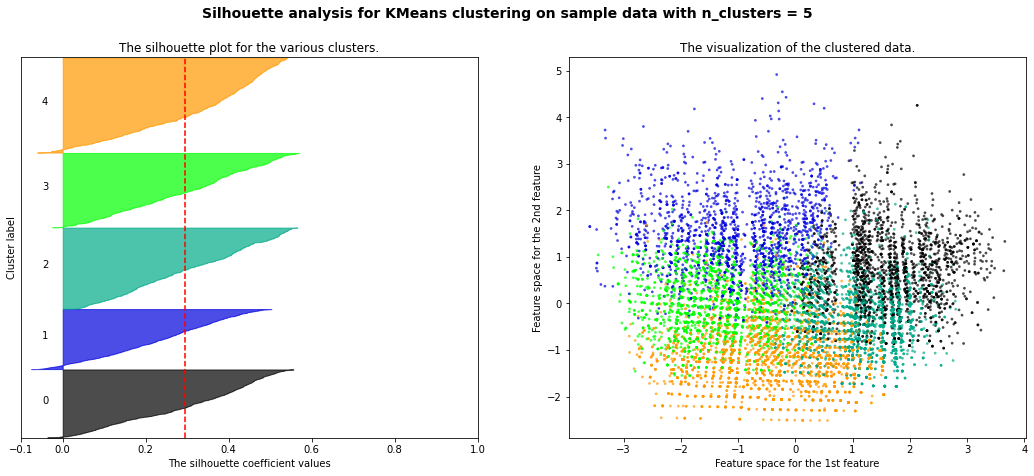

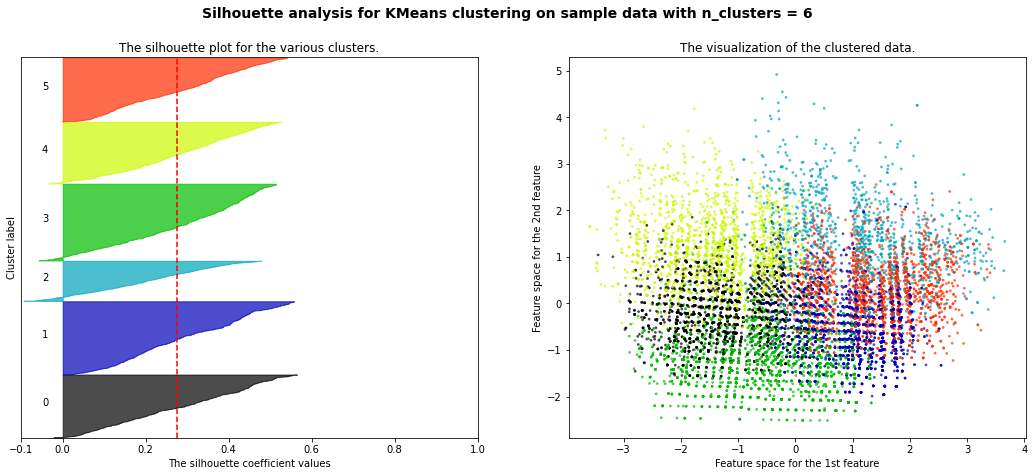

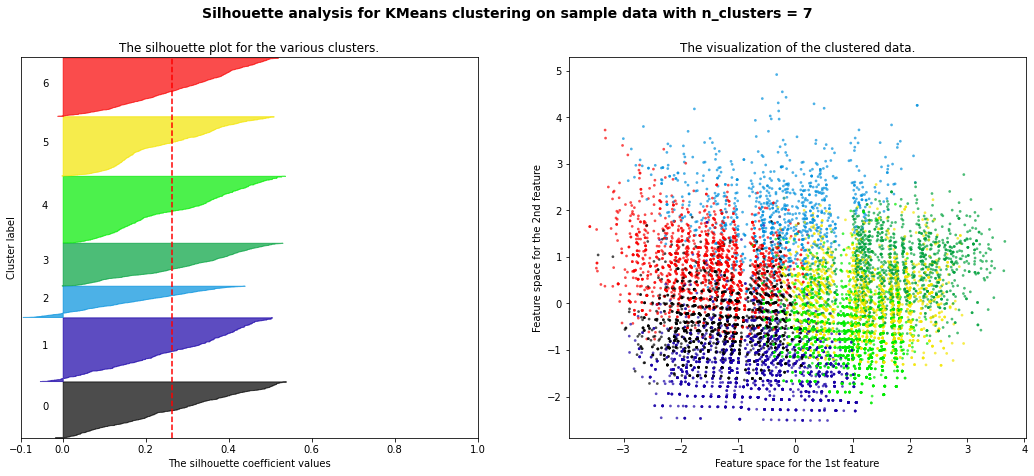

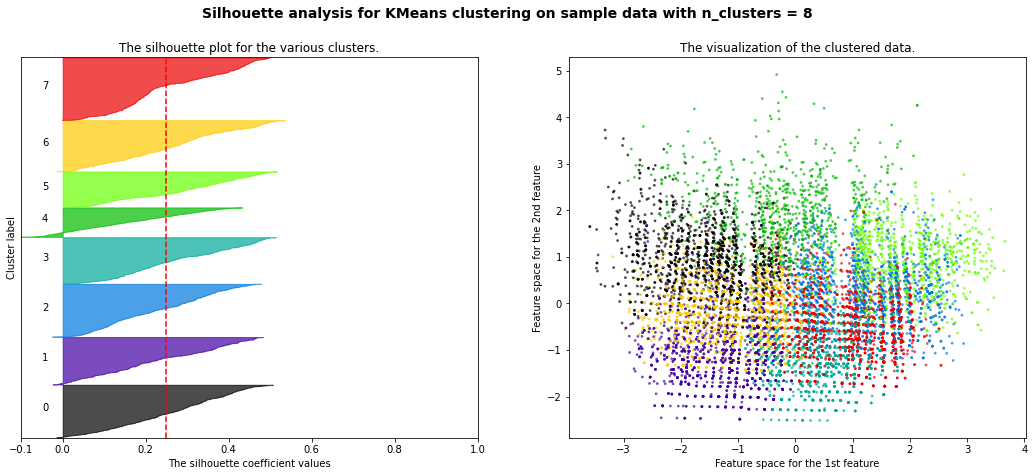

In [170]:
# labels_kmeans

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)#, sample_size=50)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca_2[:,0], X_pca_2[:,1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_



    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()



Le score silhouette semble indiquer qu'il serait judicieux d'utiliser 2 clusters au vu de l'average silhouette_score (0.3915866346729542) soit le meilleur résultat, cela donnerait 2 clusters presque similaire en nbr, 
les coefficients de silhouette semble equilibrés (pas trop proche de 1) , ce qui explique que les clusters ne soit pas isolés les uns des autres

On constate que des valeurs negatives se manifestent au dela de 3clusters, ce qui peut expliquer la mauvaise affectation a certains clusters 

## 7.2 Score silhouette (weather)

# weather

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X1, cluster_labels)#, sample_size=50)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X1[:, 0], X1[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Le score silhouette semble indiquer qu'il serait judicieux d'utiliser 2 clusters au vu de l'average silhouette_score (0.39126127093689306) soit le meilleur résultat, cela donnerait 2 clusters presque similaire en nbr, 
les coefficients de silhouette semble equilibrés (pas trop proche de 1) , ce qui explique que les clusters ne soit pas isolés les uns des autres

On constate que des valeurs negatives se manifestent des, 2 clusters, ce qui peut expliquer la mauvaise affectation a certains clusters 

# ARI

calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont affectées dans le même cluster ou dans des clusters différents dans les clusters prédits et vrais.

In [148]:
#New feature
adjusted_rand_score(labels_kmeans, X2.weather)


0.012968687523335161

In [161]:
df.sample(2)

datetime  season  holiday  workingday  weather   temp  \
5571  2012-01-07 06:00:00       1        0           0        1  10.66   
5180  2011-12-09 22:00:00       4        0           1        1  11.48   

       atemp  humidity  windspeed  casual  registered  count  label_kmeans  
5571  13.635        75     7.0015       0           7      7             2  
5180  15.910        87     0.0000      15         114    129             2

In [ ]:
df.to_csv('df.csv')

## 9. Regression sur label_kmeans => Autre notebook

## 10. Combien de forfaits faudrait-il proposer?